In [1]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from copy import copy
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

from hdbscan import validity_index as DBCV
from clustering_utils import clustering_by_methods,\
                             clustering,\
                             plot_clustering_scatter,\
                             davies_bouldin_score_precomputed,\
                             prediction_strength_CV,\
                             prediction_strength_CV_precomputed

from utils import entropy

import warnings
warnings.simplefilter("ignore")
%autoreload 2

# see the paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5
PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0
DATA_PRESERVED_THRESHOLD = 0.9

plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

# Load data

In [2]:
CPT = 0.01 # minimal percentage of the data in single cluster
DATA_SPECIFICATION = '' #'_pat0.7'

clustering_results_root = f'results/clustering_cpt-{CPT}{DATA_SPECIFICATION}' #+ '_small_datasets'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

In [3]:
# datasets_names = ['Sanger', 'Illumina', 'Pyroseq']
# tax_names = ['g']

datasets_names = ['AGP', 'HMP']
tax_names = ['o', 'f', 'g']

data_orig = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        
try:
    data_embeddings = defaultdict(dict)
    embeddings_indexes = defaultdict(dict)
    embeddings_path = f'./results/embeddings{DATA_SPECIFICATION}'

    for emb_path in glob.glob(embeddings_path + '/*'):
        label_info = emb_path.split('/')[-1].split('.')[0]
        dataset, tax, embedding_type = label_info.split('_')
        d = np.load(emb_path, allow_pickle=True).item()
        label = dataset + '_' + tax
        data_embeddings[embedding_type][label] = d['Z_']
        embeddings_indexes[embedding_type][label] = d['inliers_indexes_mae']
        
except Exception as e:
    print(e)
    pass
    
distance_root = f'distances_processed{DATA_SPECIFICATION}'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.69it/s]


In [7]:
clustering_results_root

'results/clustering_cpt-0.01'

In [8]:
!ls -la results/clustering_cpt-0.01/

total 143152
drwxr-xr-x  2 ibulygin users     4096 апр 13 19:38 .
drwxr-xr-x 19 ibulygin users     4096 апр 13 00:49 ..
-rw-r--r--  1 ibulygin users 13576666 апр 13 19:38 ae_cluster_results.npy
-rw-r--r--  1 ibulygin users 11391544 апр 13 16:38 BC_cluster_results.npy
-rw-r--r--  1 ibulygin users 14215427 апр 13 18:02 isomap_cluster_results.npy
-rw-r--r--  1 ibulygin users 12561772 апр 13 15:30 JS_cluster_results.npy
-rw-r--r--  1 ibulygin users  9228290 апр 13 13:15 L1_cluster_results.npy
-rw-r--r--  1 ibulygin users 10943694 апр 13 14:22 L2_cluster_results.npy
-rw-r--r--  1 ibulygin users 13613560 апр 13 17:09 lle_cluster_results.npy
-rw-r--r--  1 ibulygin users 15540956 апр 13 01:28 pca_cluster_results.npy
-rw-r--r--  1 ibulygin users 14199158 апр 13 18:58 spectral_cluster_results.npy
-rw-r--r--  1 ibulygin users 15280470 апр 13 17:35 tsne_cluster_results.npy
-rw-r--r--  1 ibulygin users 16003590 апр 13 18:28 umap_cluster_results.npy


# Clustering: precomputed distances

In [9]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [10]:
y_enterotypes = np.load('enterotypes_clf.npy', allow_pickle=True).item()
preprocessing_mask = np.load('preprocessing_mask.npy', allow_pickle=True).item()

In [37]:
results_dist_enterotypes = []

for distance_name, distances_ in tqdm(distances_orig.items()):

    for (label,D) in distances_.items():
        
        results = {}
        
        dataset_name, tax_name = label.split('_')
        
        labels = y_enterotypes[dataset_name]
        data_mask = preprocessing_mask[label]
        
        label_origin_mask = preprocessing_mask[dataset_name + '_g']
        label_universal = -np.ones_like(label_origin_mask, dtype=int)
        label_universal[label_origin_mask] = labels
        
        labels = label_universal[data_mask]
        mask = labels != -1
        
        labels = labels[mask].astype(int)

        results['dbind'] = davies_bouldin_score_precomputed(D[mask][:,mask], labels)
        results['silh'] = silhouette_score(D[mask][:,mask], labels, metric='precomputed')
        results['dbcv'] = DBCV(D[mask][:,mask], labels, metric='precomputed', d=data_orig[label].shape[1])
        results['ps'] = prediction_strength_CV_precomputed(D[mask][:,mask], y=labels)
        results['emb_type'] = distance_name
        

        # data mass distribution
        n = len(np.unique(labels))
        cl_dist = np.ones(n)
        for i in range(n):
            cl_dist[i] = sum(labels == i)/len(labels)

        results['entropy'] = entropy(cl_dist)
        
        results_dist_enterotypes.append(results)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.09s/it]


In [38]:
df_ent_dist = pd.DataFrame(results_dist_enterotypes)

In [40]:
results_pca_enterotypes = []

for label, X in tqdm(data_pca.items()):

    results = {}

    dataset_name, tax_name = label.split('_')

    labels = y_enterotypes[dataset_name]
    data_mask = preprocessing_mask[label]

    label_origin_mask = preprocessing_mask[dataset_name + '_g']
    label_universal = -np.ones_like(label_origin_mask, dtype=int)
    label_universal[label_origin_mask] = labels
    labels = label_universal[data_mask]
    
    mask = labels != -1

    labels = labels[mask].astype(int)

    results['dbind'] = davies_bouldin_score(X[mask], labels)
    results['silh'] = silhouette_score(X[mask], labels)
    results['dbcv'] = DBCV(X[mask], labels, d=data_orig[label].shape[1])
    results['ps'] = prediction_strength_CV(X[mask], y=labels)

    # data mass distribution
    n = len(np.unique(labels))
    cl_dist = np.ones(n)
    for i in range(n):
        cl_dist[i] = sum(labels == i)/len(labels)

    results['entropy'] = entropy(cl_dist)

    results_pca_enterotypes.append(results)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


In [41]:
df_ent_pca = pd.DataFrame(results_pca_enterotypes)
df_ent_pca['emb_type']  = 'pca'

In [32]:
results_emb_enterotypes = []

for emb_type, emb_dict in data_embeddings.items():

    for label, X in tqdm(emb_dict.items()):

        results = {}

        dataset_name, tax_name = label.split('_')

        labels = y_enterotypes[dataset_name]
        data_mask = preprocessing_mask[label]

        label_origin_mask = preprocessing_mask[dataset_name + '_g']
        label_universal = -np.ones_like(label_origin_mask, dtype=int)
        label_universal[label_origin_mask] = labels
        labels = label_universal[data_mask]
        
        inliers = embeddings_indexes[emb_type][label]
        labels = labels[inliers]
        X = X.astype(np.double)

        mask = labels != -1

        labels = labels[mask].astype(int)

        results['dbind'] = davies_bouldin_score(X[mask], labels)
        results['silh'] = silhouette_score(X[mask], labels)
        results['dbcv'] = DBCV(X[mask], labels, d=data_orig[label].shape[1])
        results['ps'] = prediction_strength_CV(X[mask], y=labels)
        results['emb_type'] = emb_type

        # data mass distribution
        n = len(np.unique(labels))
        cl_dist = np.ones(n)
        for i in range(n):
            cl_dist[i] = sum(labels == i)/len(labels)

        results['entropy'] = entropy(cl_dist)

        results_emb_enterotypes.append(results)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.21it/s]


In [39]:
df_ent_emb = pd.DataFrame(results_emb_enterotypes)

In [43]:
clustering_results_df_ = pd.concat([df_ent_dist, df_ent_pca, df_ent_emb])

In [45]:
clustering_results_df_

,dbind,silh,dbcv,ps,emb_type,entropy
0,3.685068,0.079380,-0.961455,0.241957,L1,0.973831
1,1.567396,0.195698,-0.757271,0.700474,L1,0.973831
2,2.127460,0.209495,-0.762149,0.756536,L1,0.973831
3,2.461100,0.013322,-0.977626,0.526837,L1,0.963091
4,1.770248,0.158961,-0.880641,0.818770,L1,0.963259
...,...,...,...,...,...,...
31,2.846104,0.024808,-0.924842,0.840823,ae,0.982799
32,1.977350,0.107315,-0.941619,0.849555,ae,0.976022
33,1.964588,0.120674,-0.929991,0.747747,ae,0.990306
34,5.531779,0.002622,-0.986955,0.354413,ae,0.990843


# Davies-Bouldin index and Silhoutte score, entropy coloring

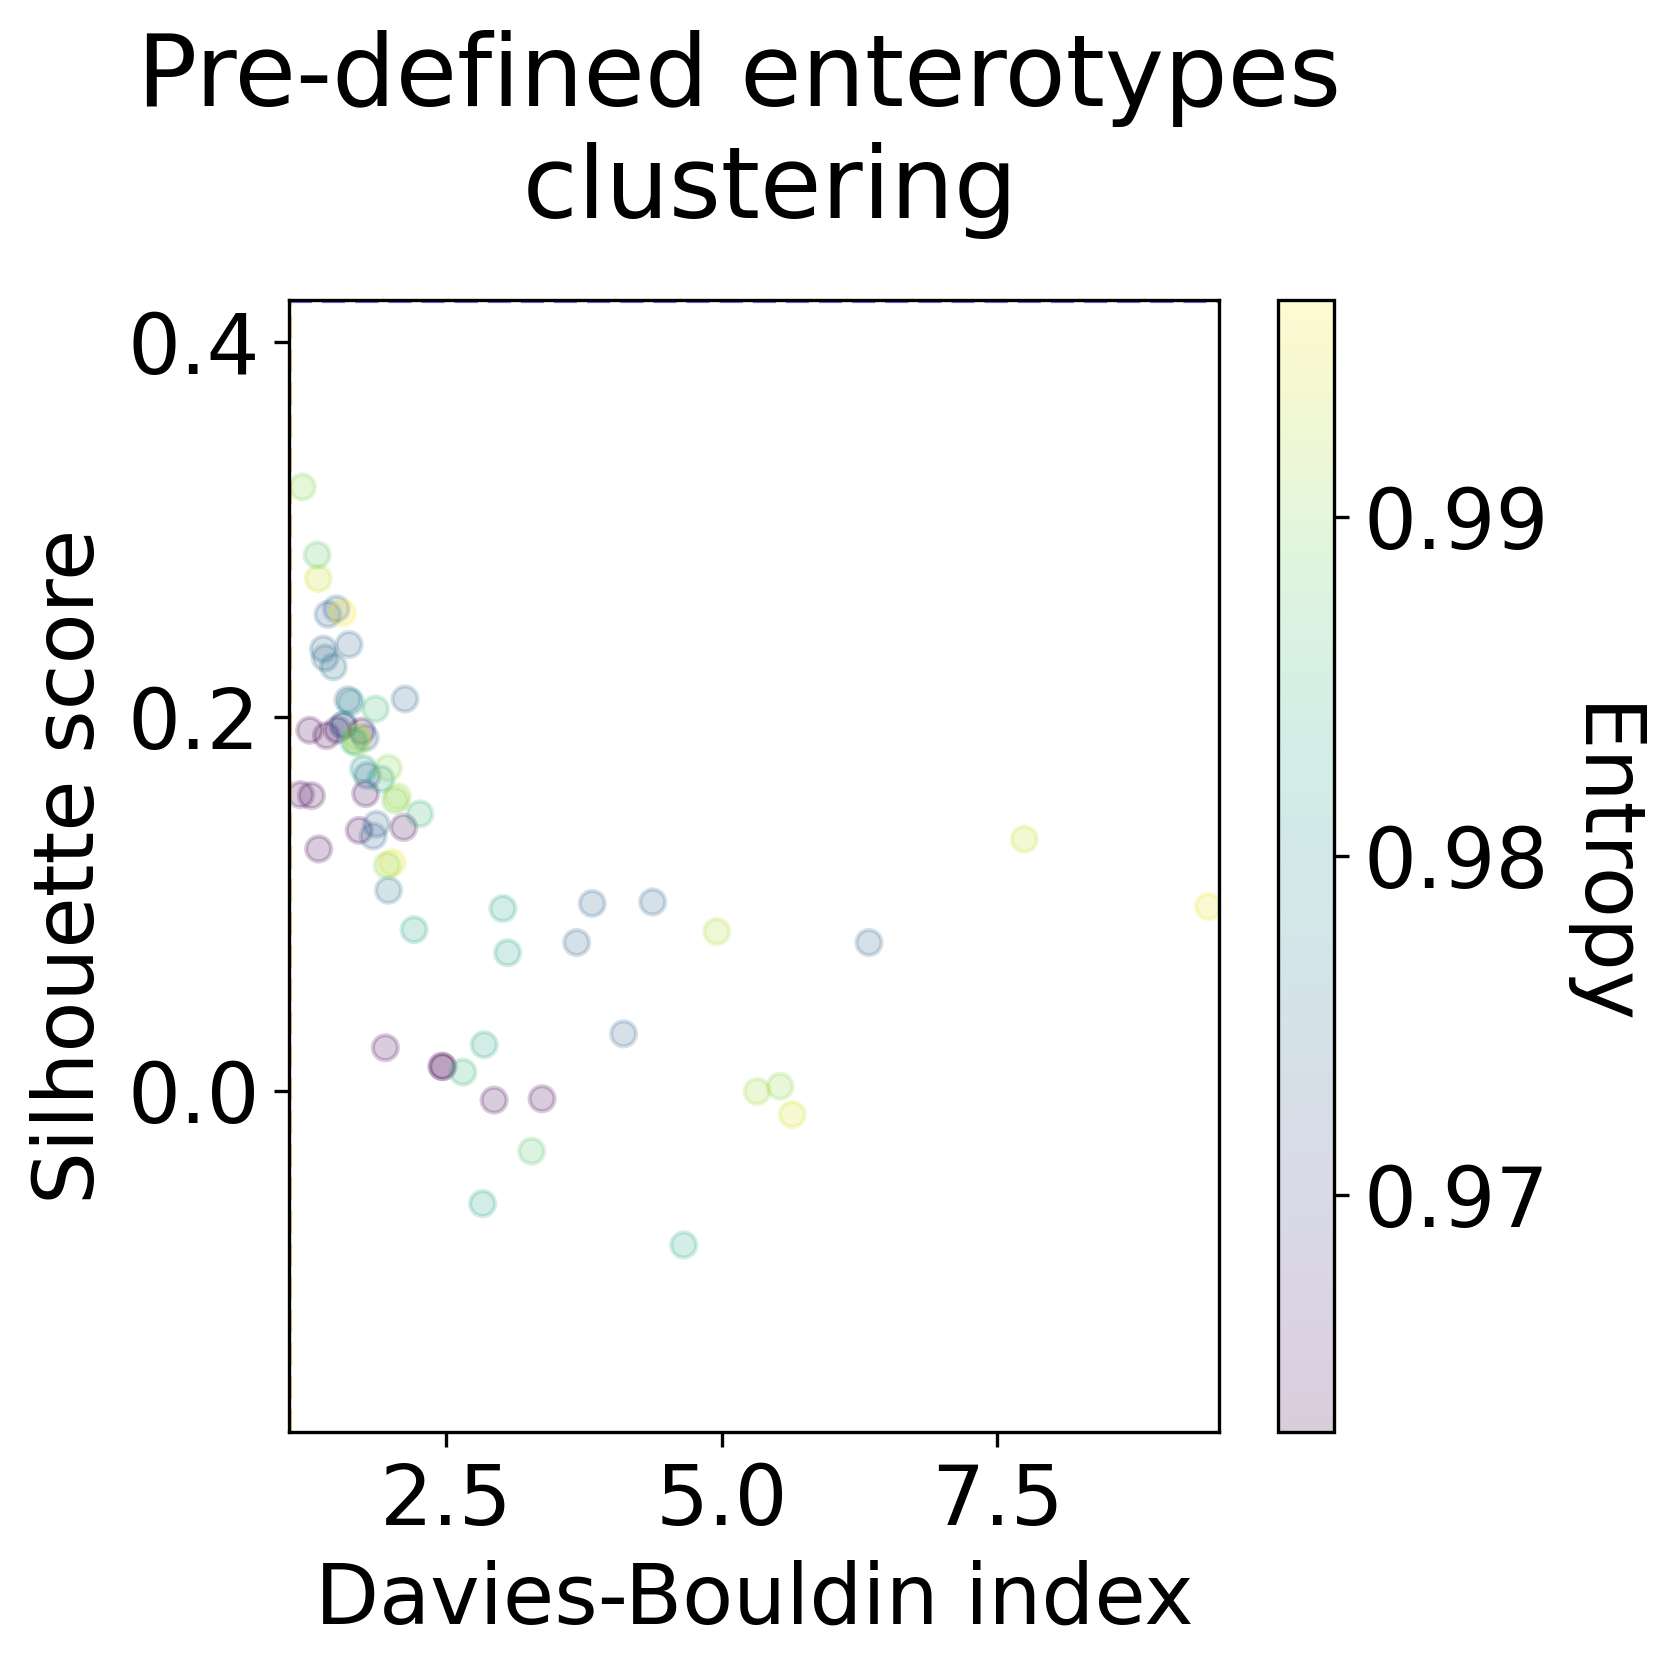

In [49]:
plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

plot_clustering_scatter(clustering_results_df_, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Pre-defined enterotypes \n clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

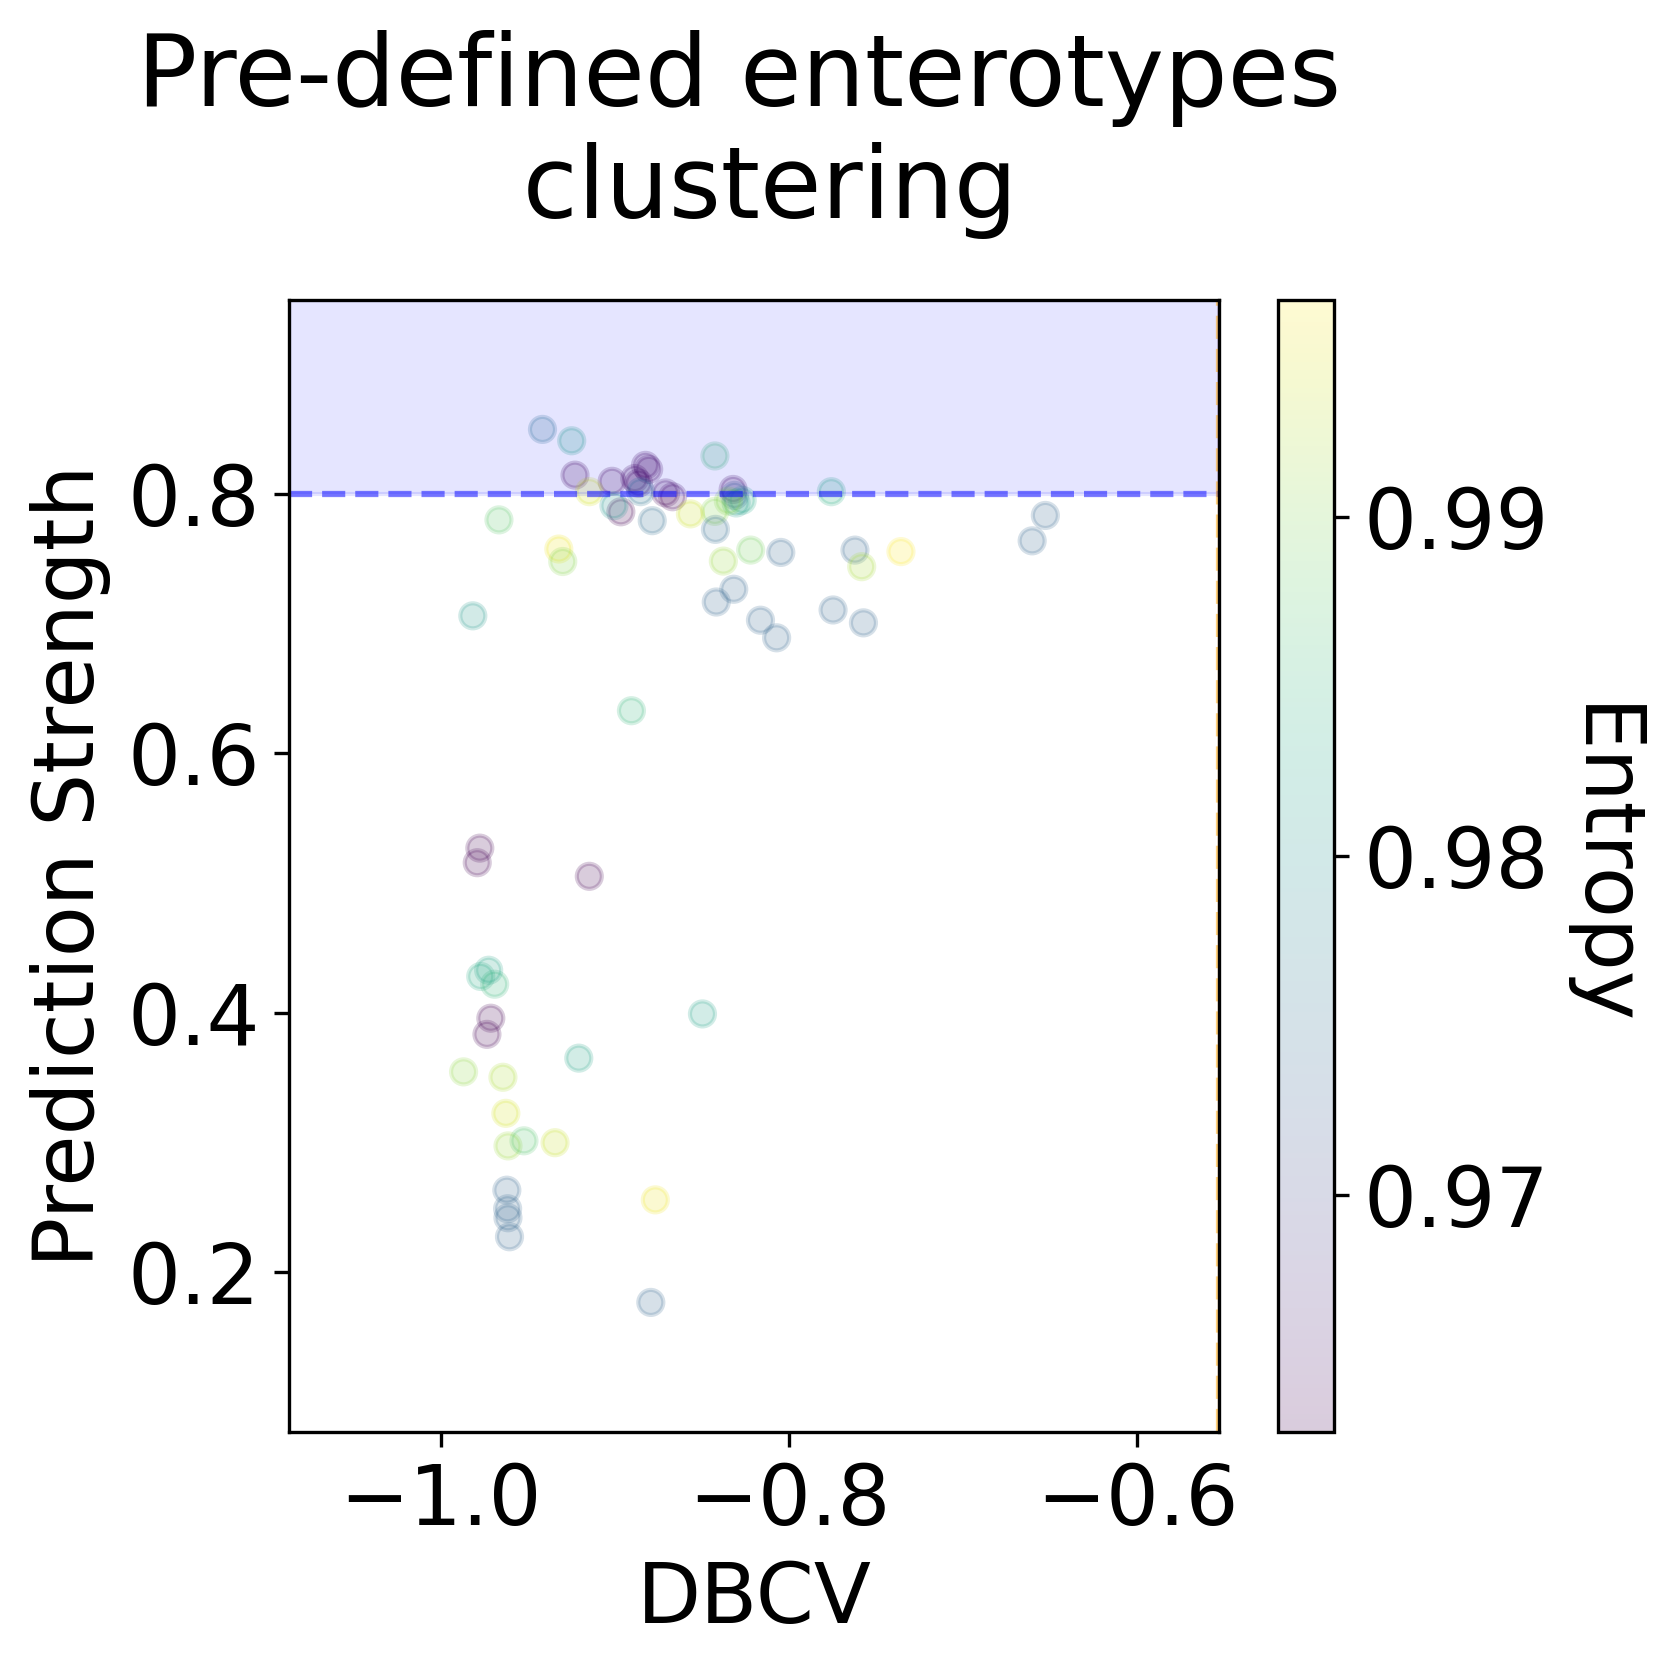

In [50]:

plot_clustering_scatter(clustering_results_df_, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Pre-defined enterotypes \n clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )